<a href="https://colab.research.google.com/github/BUGATAASHWINI/ML-Training-/blob/main/Task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [7]:
path = "/content/breast-cancer.csv"
data = pd.read_csv(path)

In [11]:
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']

# Assuming 'diagnosis' column contains 'M' and 'B'
# Convert 'M' to 1 and 'B' to 0
y = y.map({'M': 1, 'B': 0})

feature_names = X.columns.tolist()
target_names = ['B', 'M'] # Based on the mapping above

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])

rbf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_linear = {
    "svm__C": [0.01, 0.1, 1, 10, 100]
}

param_grid_rbf = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
}

In [15]:
grid_linear = GridSearchCV(
    estimator=linear_pipeline,
    param_grid=param_grid_linear,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)
grid_rbf = GridSearchCV(
    estimator=rbf_pipeline,
    param_grid=param_grid_rbf,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)


In [16]:
grid_linear.fit(X_train, y_train)
grid_rbf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='accuracy')

In [17]:
scoring = {"acc": "accuracy", "prec": "precision", "rec": "recall", "f1": "f1"}

cv_linear = cross_validate(grid_linear.best_estimator_, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_rbf = cross_validate(grid_rbf.best_estimator_, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

def summarize_cv(cv_res):
    return {
        "accuracy_mean": np.mean(cv_res["test_acc"]),
        "precision_mean": np.mean(cv_res["test_prec"]),
        "recall_mean": np.mean(cv_res["test_rec"]),
        "f1_mean": np.mean(cv_res["test_f1"]),
    }

summary_linear = summarize_cv(cv_linear)
summary_rbf = summarize_cv(cv_rbf)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_linear = grid_linear.best_estimator_.fit(X_train, y_train)
best_rbf = grid_rbf.best_estimator_.fit(X_train, y_train)


In [19]:
def holdout_metrics(model, X_tr, y_tr, X_te, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    return {
        "train_acc": accuracy_score(y_tr, y_pred_tr),
        "test_acc": accuracy_score(y_te, y_pred_te),
        "test_prec": precision_score(y_te, y_pred_te),
        "test_rec": recall_score(y_te, y_pred_te),
        "test_f1": f1_score(y_te, y_pred_te),
    }

hold_linear = holdout_metrics(best_linear, X_train, y_train, X_test, y_test)
hold_rbf = holdout_metrics(best_rbf, X_train, y_train, X_test, y_test)

In [22]:
# from caas_jupyter_tools import display_dataframe_to_user

def tidy_grid_results(grid, model_name):
    df = pd.DataFrame(grid.cv_results_)
    df = df[
        [c for c in df.columns if c.startswith("param_")] +
        ["mean_test_score", "std_test_score", "rank_test_score"]
    ].sort_values("rank_test_score")
    df.insert(0, "model", model_name)
    return df

In [24]:
df_grid_linear = tidy_grid_results(grid_linear, "SVM-linear")
df_grid_rbf = tidy_grid_results(grid_rbf, "SVM-RBF")

display(df_grid_linear)
display(df_grid_rbf)

,model,param_svm__C,mean_test_score,std_test_score,rank_test_score
1,SVM-linear,0.10,0.967033,0.006950,1
2,SVM-linear,1.00,0.964835,0.010767,2
0,SVM-linear,0.01,0.962637,0.013187,3
3,SVM-linear,10.00,0.960440,0.016447,4
4,SVM-linear,100.00,0.960440,0.011207,4


,model,param_svm__C,param_svm__gamma,mean_test_score,std_test_score,rank_test_score
15,SVM-RBF,10.0,0.01,0.975824,0.010767,1
12,SVM-RBF,10.0,scale,0.975824,0.008223,1
13,SVM-RBF,10.0,auto,0.975824,0.008223,1
20,SVM-RBF,100.0,0.001,0.973626,0.011207,4
7,SVM-RBF,1.0,auto,0.971429,0.005383,5
6,SVM-RBF,1.0,scale,0.971429,0.005383,5
21,SVM-RBF,100.0,0.01,0.969231,0.008223,7
14,SVM-RBF,10.0,0.001,0.964835,0.012815,8
18,SVM-RBF,100.0,scale,0.964835,0.008223,9
19,SVM-RBF,100.0,auto,0.964835,0.008223,9


In [25]:
print("=== Best params ===")
print("Linear:", grid_linear.best_params_)
print("RBF   :", grid_rbf.best_params_)
print("\n=== CV (mean across folds) ===")
print("Linear:", summary_linear)
print("RBF   :", summary_rbf)
print("\n=== Hold-out metrics ===")
print("Linear:", hold_linear)
print("RBF   :", hold_rbf)

=== Best params ===
Linear: {'svm__C': 0.1}
RBF   : {'svm__C': 10, 'svm__gamma': 'scale'}

=== CV (mean across folds) ===
Linear: {'accuracy_mean': np.float64(0.9670329670329669), 'precision_mean': np.float64(0.9771428571428572), 'recall_mean': np.float64(0.9352941176470588), 'f1_mean': np.float64(0.9548173203607986)}
RBF   : {'accuracy_mean': np.float64(0.9758241758241759), 'precision_mean': np.float64(0.97109243697479), 'recall_mean': np.float64(0.9647058823529411), 'f1_mean': np.float64(0.9674103219883271)}

=== Hold-out metrics ===
Linear: {'train_acc': 0.9824175824175824, 'test_acc': 0.9824561403508771, 'test_prec': 1.0, 'test_rec': 0.9523809523809523, 'test_f1': 0.975609756097561}
RBF   : {'train_acc': 0.989010989010989, 'test_acc': 0.9736842105263158, 'test_prec': 1.0, 'test_rec': 0.9285714285714286, 'test_f1': 0.9629629629629629}


In [26]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_std)
X_test_2d = pca.transform(X_test_std)

In [27]:
best_C_linear = grid_linear.best_params_["svm__C"]
clf_linear_2d = SVC(kernel="linear", C=best_C_linear)
clf_linear_2d.fit(X_train_2d, y_train)

best_C_rbf = grid_rbf.best_params_["svm__C"]
best_gamma_rbf = grid_rbf.best_params_["svm__gamma"]
clf_rbf_2d = SVC(kernel="rbf", C=best_C_rbf, gamma=best_gamma_rbf)
clf_rbf_2d.fit(X_train_2d, y_train)


SVC(C=10)

In [28]:
def plot_decision_boundary(model, X2d, y, title):
    # Build mesh grid
    x_min, x_max = X2d[:, 0].min() - 1.0, X2d[:, 0].max() + 1.0
    y_min, y_max = X2d[:, 1].min() - 1.0, X2d[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X2d[:, 0], X2d[:, 1], c=y, edgecolor="k", alpha=0.8)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    plt.tight_layout()
    # Show the plot
    plt.show()

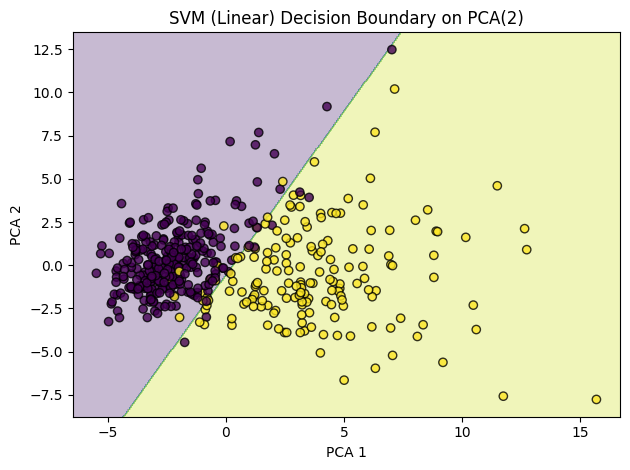

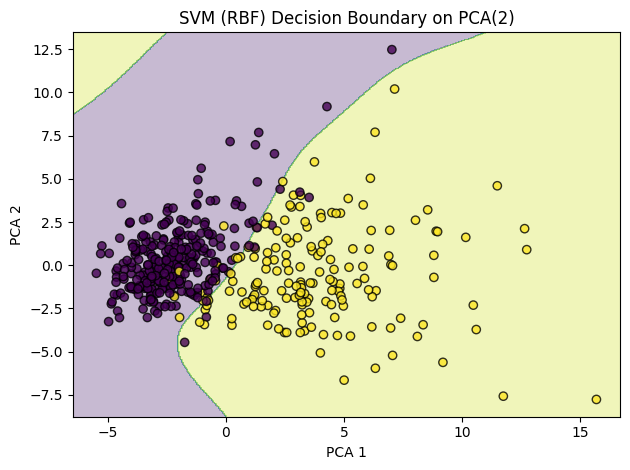

In [29]:
plot_decision_boundary(clf_linear_2d, X_train_2d, y_train, "SVM (Linear) Decision Boundary on PCA(2)")
plot_decision_boundary(clf_rbf_2d, X_train_2d, y_train, "SVM (RBF) Decision Boundary on PCA(2)")

# Also show confusion matrices for the best full-dimensional models on the test set
y_test_pred_linear = best_linear.predict(X_test)
y_test_pred_rbf = best_rbf.predict(X_test)

<Figure size 640x480 with 0 Axes>

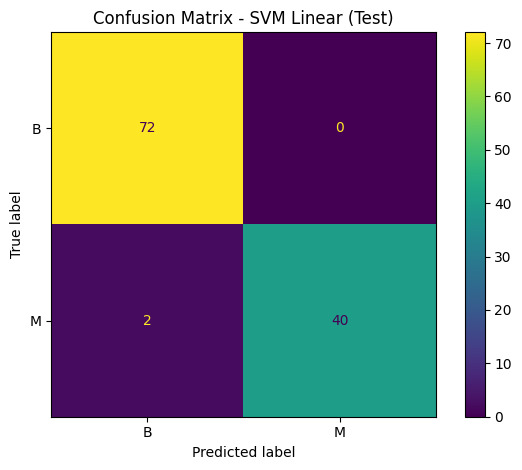

In [30]:
cm_linear = confusion_matrix(y_test, y_test_pred_linear)
cm_rbf = confusion_matrix(y_test, y_test_pred_rbf)

fig = plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=target_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix - SVM Linear (Test)")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

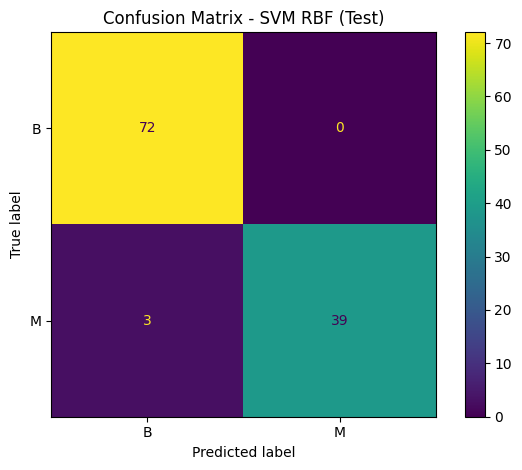

['/content/pca_2d.joblib']

In [32]:
fig = plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=target_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix - SVM RBF (Test)")
plt.tight_layout()
plt.show()

# Save best models and PCA/scaler if the user wants to reuse
import joblib
joblib.dump(grid_linear.best_estimator_, "/content/svm_linear_best.joblib")
joblib.dump(grid_rbf.best_estimator_, "/content/svm_rbf_best.joblib")
joblib.dump(scaler, "/content/standard_scaler.joblib")
joblib.dump(pca, "/content/pca_2d.joblib")